<a href="https://colab.research.google.com/github/cirilwakounig/MachineLearning/blob/main/7_Data_Leakage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Leakage

This script shows, how to deal with data leakage and is based on the tutorial provided by Kaggle.

Data leakage happens, when you training data contains information about the target, but similar data will not be available when the model is used for prediction. 

There are two different types of leakage:

* **Target Leakage**: Occurs, when your features contain data, that will not be available at the time you make predictions. As an example, taking medicines against cancer heavily correlates with people having cancer, however in order to predict cancer, one cannot use this information, as they would not be already taking cancer medication. To prevent this type of data leakage, any variable updated (or created) after the target value is realised should be excluded. 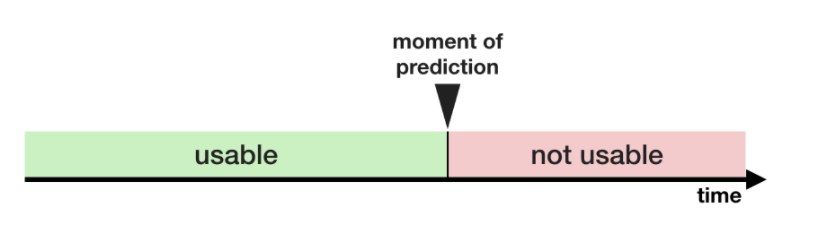
* **Train-test Contamination**: Occurs when you aren't careful to distinguish training data from validation data. For example, imagine preprossing (e.g. fitting an imputer) before running test_train_split(). The model would get very good validation scores on the validation set, but not on a real world example. If the validation is based on any simple train-test split, exclude the validation data from any type of *fitting*, including the fitting of preprocessing steps. Using sklearn pipelines makes this easier, and pipelining is especially important when deploying cross validation data. 


In [ ]:
# Import the required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Data Processing
from sklearn.model_selection import train_test_split

# Pipeling
from sklearn.pipeline import make_pipeline

# Validation
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error

#### 1. Import and Process the required Data

---



##### 1.1 Import of Data

In [ ]:
# Import the Data Set Set
file_path = '/content/drive/MyDrive/Colab Notebooks/Kaggle Course/Intermediate Machine Learning/AER_credit_card_data.csv'


# Read the data
data = pd.read_csv(file_path, true_values= ['yes'], false_values=['no'])

# Select Target
y = data.card

# Separate features from target
X = data.drop(['card'], axis = 1)

X.head()
#X_train, X_val, y_train, y_val = train_test_split(X, y, train_size = 0.8,
                                                  #test_size = 0.2, random_state = 0)

,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
0,0,37.66667,4.5200,0.033270,124.983300,True,False,3,54,1,12
1,0,33.25000,2.4200,0.005217,9.854167,False,False,3,34,1,13
2,0,33.66667,4.5000,0.004156,15.000000,True,False,4,58,1,5
3,0,30.50000,2.5400,0.065214,137.869200,False,False,0,25,1,7
4,0,32.16667,9.7867,0.067051,546.503300,True,False,2,64,1,5


#### 2. Pipeline Development

---

Since this is a small dataset, we will have to apply cross validation. Cross validation is best performed using pipelines. However, since there is no preprocessing, a real pipeline is not necessary. 


In [ ]:
# Automate pipeline generation
my_pipe = make_pipeline(RandomForestClassifier(n_estimators=100))

# Cross Validation
cv_scores = cross_val_score(my_pipe, X, y, cv = 5, scoring = 'accuracy')

# Print the mean of the scores
print("Cross-validation accuracy: %f" % cv_scores.mean())

Cross-validation accuracy: 0.980294


With experience, you'll find that it's very rare to find models that are accurate 98% of the time. It happens, but it's uncommon enough that we should inspect the data more closely for target leakage.

#### 3. Discussing Data Leakage

---



In order to check variables for data leakage, one needs to look at the different features.

Here is a summary of the data, which you can also find under the data tab:

* card: 1 if credit card application accepted, 0 if not
* reports: Number of major derogatory reports
* age: Age n years plus twelfths of a year
* income: Yearly income (divided by 10,000)
* share: Ratio of monthly credit card expenditure to yearly income
* expenditure: Average monthly credit card expenditure
* owner: 1 if owns home, 0 if rents
* selfempl: 1 if self-employed, 0 if not
* dependents: 1 + number of dependents
* months: Months living at current address
* majorcards: Number of major credit cards held
* active: Number of active credit accounts

A few variables look suspicious. For example, does expenditure mean expenditure on this card or on cards used before appying?

At this point, basic data comparisons can be very helpful:


In [ ]:
expenditures_cardholders = X.expenditure[y]
expenditures_noncardholders = X.expenditure[~y]

print('Fraction of those who did not receive a card and had no expenditures: %.2f' % (expenditures_noncardholders == 0).mean())
print('Fraction of those who received a card and had no expenditures: %.2f' % (expenditures_cardholders == 0).mean())

Fraction of those who did not receive a card and had no expenditures: 1.00
Fraction of those who received a card and had no expenditures: 0.02


As shown above, everyone who did not receive a card, did not have any expenditures, while only 2% of those who received a card had no expenditures. It is not surprising that the model is very accurate. The parameter expenditures should be excluded. 

The parameter share is also determined by expenditure, it should be excluded as well. The variables active and majorcards are a little less clear, but from the description, they sound concerning. In most situations, it's better to be safe than sorry if you can't track down the people who created the data to find out more.

Rerun the model without the features in question.



In [ ]:
# dropping features
potential_leaks = ["expenditure", "share", "active", "majorcards"]
X2 = X.drop(potential_leaks, axis = 1)

# Evaluate the model without leaky features
cv_scores = cross_val_score(my_pipe, X2, y, cv = 5, scoring = 'accuracy')

print('Cross-Validation Accurarcy: %f' % cv_scores.mean())

Cross-Validation Accurarcy: 0.828655


#### 4. Conclusion

This accuracy is quite a bit lower, which might be disappointing. However, we can expect it to be right about 80% of the time when used on new applications, whereas the leaky model would likely do much worse than that (in spite of its higher apparent score in cross-validation).

Data leakage can be multi-million dollar mistake in many data science applications. Careful separation of training and validation data can prevent train-test contamination, and pipelines can help implement this separation. Likewise, a combination of caution, common sense, and data exploration can help identify target leakage.